In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Logistic classification: Maximum-likelihood fitting

In the [last notebook](classification_logistic_regression_model.ipynb) we decribed the logistic classification model which comprised two stages. First a linear transformation of the inputs produces the activations

$$
a_n = \mathbf{w}^\top \mathbf{x}_n = \sum_{d=1}^D w_d x_{n,d}.
$$

Second, the model passes the activation through a non-linear logistic function to yield the probability that the data point belongs to the first class

$$
p(y_n = 1 | \mathbf{x}_n, \mathbf{w}) = \sigma(a_n)  = \frac{1}{1 + \text{exp}({-\mathbf{w}_n^\top \mathbf{x}})} .
$$

The last notebook aimed to understand the model. The next question is how to go about learning the weights $\mathbf{w}$, given the training examples $\{\mathbf{x}_n, y_n\}^N_{n=1}$. Here we describe how to do this using maximum likelihood estimation.

### Maximum likelihood estimation

In the maximum likelihood approach the aim is to maximise the probability of the training outputs given the training inputs and the weights

$$
\mathbf{w}_{\text{ML}} = \arg\max\limits_{\mathbf{w}} p(\{ y_n \}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}) \;\; \text{where} \;\;
p(\{ y_n \}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}) = \prod^N_{n = 1} p(y_n|\mathbf{x}_n, \mathbf{w}).
$$

We can now substitute in the model's input-output function $p(y_n=1|\mathbf{x}_n, \mathbf{w}) = \sigma(\mathbf{w}^\top\mathbf{x}_n)$ into the likelihood. Using the fact that the ouput $y_n$ is either $0$ or $1$ leads to a compact expression 

$$
p(\{ y_n \}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}) = \prod^N_{n = 1} \sigma(\mathbf{w}^\top\mathbf{x}_n)^{y_n} \big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)^{1-y_n}.
$$

If this step is not obvious, consider one datapoint $N=1$ and the cases where $y_1 = 0$ and $y_1=1$ and show the expression above recovers the correct result. As we previously stated in the regression section, maximising the likelihood is equivalent to maximising the log-likelihood (or minimising the negative log-likelihood). Taking the logarithm turns the product of data-points into a sum which is mathematically and computationally simpler to handle 

$$
\mathcal{L}(\mathbf{w}) =\text{log}~p(\{ y_n \}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}) = \sum^N_{n = 1} \left[ y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big) \right].
$$

In order to locate the maximum of this quantity we take derivatives with respect to the weights
\begin{align}
\frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}} = \sum^N_{n = 1} \big(y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n\\
\end{align} 

This expression takes a few lines to derive (see below for full details). The derivative has an intuitive form: for each training data-point take the prediction error $y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)$, multiply it by the input $\mathbf{x}_n$ and sum to get the derivative. In this way, points that are correctly predicted don't contribute to the derivative: they are happy already! 

<details>
<summary>Detailed computation of derivative</summary>
<div class="row">
  <div class="column">
  
   In order to take the derivative of $\mathcal{L}$ with respect to $\mathbf{w}$, we use the following handy result for the derviative of the logistic function:

\begin{align}
\frac{\partial \sigma(x)}{\partial x} = \frac{e^{-x}}{(1 + e^{-x})^2} = \big(1 - \sigma(x)\big)\sigma(x)
\end{align}

This identity can be used as follows:

\begin{align}
\frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}} &= \nabla\sum^N_{n = 1} \left[ y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\right]\\
~\\
&= \sum^N_{n = 1} \left[ y_n \big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n - (1-y_n)\sigma(\mathbf{w}^\top\mathbf{x}_n)\mathbf{x}_n\right]\\
~\\
&= \sum^N_{n = 1} \big(y_n - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big)\mathbf{x}_n\\
\end{align} 
  </div>
</div>
</details>

Ideally, one might like to analytically find the maximum likelihood weights by setting this derivative to zero and solving for $\mathbf{w}_{\text{ML}}$, just as is done for linear regression. Unfortunately, there is no general analytic solution for classification. Instead, the likelihood can be numerically optimised. Here we will use one of the most simple and widely used numerical optimisation algorithms called **gradient ascent**. Gradient ascent is an iterative procedure that produces weights on iteration i+1,  $\mathbf{w}_{i+1}$, by adding to the old weight $\mathbf{w}_{i}$ the gradient of the objective at the old weight $\frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}}\bigg|_{\mathbf{w}_{i}}$ times a learning rate $\eta$ (also called the stepsize),

\begin{align}
\mathbf{w}_{i+1} = \mathbf{w}_{i} + \eta \frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}}\bigg|_{\mathbf{w}_{i}}.
\end{align}

The rationale for this update is shown in the schematic below. 

<img src="gradient-ascent-schematic.svg" alt="Snow" style="width:80%; float: center; padding: 0px; padding : 20px">

The gradient of the objective at the current parameter value points uphill towards the (local) maximum. The update therefore takes a small step $\eta$ in the direction of the gradient. If this step is small enough, the objective function will increase. Moreover, the maximum likelihood parameters are a fixed-point of the algorithm since here the gradient is zero and so the weight parameters will not change. Any local maximum (or stationary point more generally) will also be a fixed point. 

Choosing an appropriate learning rate is important. Too big and the maximum can be hopped over causing a decrease in the objective; too small and the algorithm takes a long time to converge. It is also worth noting that this method of maximising $\mathcal{L}(\mathbf{w})$ is not the only way: there are a host of different approaches which can be used. 

Let's look at an implementation of gradient ascent for binary logistic classification:

In [5]:
def sig(a):
    
    return 1/(1 + np.exp(-a)) # define logistic function for convenience

def gradient_ascent(x, y, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
        
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        
        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks) 

toggle_code(title = "gradient ascent algorithm", on_load_hide = False)

Lets now apply this algorithm. We peform the fitting first on a 1D dataset derived from the  __[Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)__. This low dimensional problem enables us to visualise the weight updates as there are only two weights to learn (the constant bias $w_0$ and the coefficient $w_1$). The dataset contains $40$ datapoints labeled $y = 0,~\text{or}~1$, which we split 50:50 to form a training set and a testing set.

Weights before: w = [0. 0.]  and after: w =  [ 1.89 -2.17]


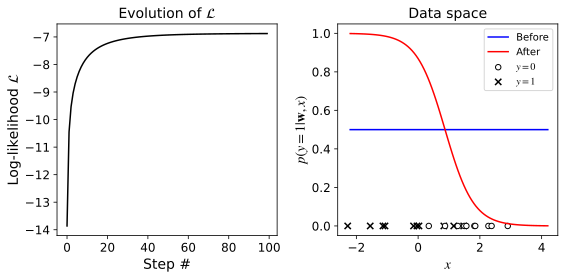

In [7]:
x = np.load('class_1d_inputs.npy')
y = np.load('class_1d_labels.npy')

x_train, x_test, y_train, y_test = x[:20], x[20:], y[:20], y[20:]


x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2


w_0 = np.array([0.0, 0.0]) # set initial weights to 0

w_history, log_liks = gradient_ascent(x_train, y_train, w_0, 10 ** 2, 1) # calling the function on the dataset

print('Weights before: w =', w_0.round(2), ' and after: w = ', w_history[-1].round(2))

# plotting code

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(log_liks, color = 'black') # plot log likelihoods
beautify_plot({"title":r"Evolution of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})

plt.subplot(1, 2, 2)

x_1, x_2 = x_train[np.where(y_train == 0)[0]], x_train[np.where(y_train == 1)[0]]

xs = np.linspace(-2.2, 4.2, 100)

plt.plot(xs, sig(xs * w_history[0, 1] + w_history[0, 0]), color = 'blue', zorder = 3, label = 'Before')
plt.plot(xs, sig(xs * w_history[-1, 1] + w_history[-1, 0]), color = 'red', zorder = 3, label = 'After')

plt.scatter(x_1, np.zeros_like(x_1), color = 'white', edgecolor = 'black', marker = 'o', s = 30,
            zorder = 2, label = '$y = 0$')
plt.scatter(x_2, np.zeros_like(x_2), color = 'black', marker = 'x', s = 40, zorder = 1, label = '$y = 1$')

beautify_plot({"title":r"Data space", "x":"$x$", "y":"$p(y = 1|\mathbf{w}, x)$"})
plt.gca().legend()
plt.tight_layout()
plt.show()

toggle_code()

The weights were initialised to zero leading to a flat input-ouput function $p(y=1|\mathbf{w},x) = 1/2$. The gradient ascent algorithm has converges quite quickly, with the log-likelihood starting to plateau within the first 20 iterations. After optimisation, the input-ouput function is sigmoid with a steep slope aligned with the transition in the data between the two classes. This next animation shows what is happening during the training:

<div class="row">
  <div class="column">
    <img src="class_1d_animation.gif" style="width:100%; float: center; padding: 0px">
  </div>
</div>

As the gradient ascent progresses, we can see the weights $(w_0, w_1)$ climb up the likelihood, in a direction normal to the functions contours. The log-likelihood $\mathcal{L}$ rapidly increases at first and then flattens out as $(w_0, w_1)$ approach the maximum of the likelihood. Close to the maximum, the gradient $\partial \mathcal{L}/\partial \mathbf{w}$ becomes smaller and smaller and so the optimiser takes smaller and smaller steps until it finally converges to the maximum. 

The contour plot of the log-likelihood suggests that for this dataset, the maximum is a global one. This begs the question: Can we prove that the logistic classification likelihood always has a single global optimum? The answer is 'yes' and a sketch proof is given below (for enthusiasts only).

<details>
<summary>Global maximum in probabilistic linear classification</summary>
<div>
In order to prove that there is a unique global maximum of the log-likelihood:

$$
\mathcal{L}(\mathbf{w}) =\text{log}~p(\mathbf{y}|\{\mathbf{x}_n\}_{n=1}^N, \mathbf{w}) = \sum^N_{n = 1} \left[ y_n\text{log}~\sigma(\mathbf{w}^\top\mathbf{x}_n)+(1-y_n)\text{log}~\big(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n)\big) \right]
$$

We must show that the second derivative matrix of the log-likelihood (also known as the Hessian matrix, which we will see again in chapter 3.3) is negative definite. This will demonstrate that the function is [concave](https://en.wikipedia.org/wiki/Concave_function), and that there is a unique maximum. We therefore start by taking the derivative of $\mathcal{L}$ with respect to $\mathbf{w}$. Note that in the following equations, for simplicity we shall use $\sigma(\cdot)$ to denote $\sigma(\mathbf{w}^\top\mathbf{x}_n)$.

$$
\frac{\partial \mathcal{L}(\mathbf{w})}{\partial \mathbf{w}} = \nabla\mathcal{L}(\mathbf{w})=\sum^N_{n = 1}\left[ \frac{y_n\nabla\sigma(\cdot)}{\sigma(\cdot)}-\frac{(1 - y_n)\nabla\sigma(\cdot)}
{1 - \nabla\sigma(\cdot)}\right]
$$

Now we find the derivative of $\sigma(\cdot)$ and substitute it back into the equation. 

\begin{align}
\nabla\sigma(\mathbf{w}^\top\mathbf{x}_n) &= \sigma(\mathbf{w}^\top\mathbf{x}_n)(1 - \sigma(\mathbf{w}^\top\mathbf{x}_n))\mathbf{x}_n\\
~\\
&= \sigma(\cdot)(1 - \sigma(\cdot))\mathbf{x}_n\\
~\\
\nabla\mathcal{L} &= \sum^N_{n = 1}\left[y_n(1 - \sigma(\cdot))\mathbf{x}_n - (1 - y_n)\sigma(\cdot)\mathbf{x}_n\right]\\
~\\
&=  \sum^N_{n = 1}\left[\mathbf{x}_n(y_n - \sigma(\cdot)\right]\\
\end{align}

Now differentiating again:

\begin{align}
\nabla\nabla\mathcal{L}(\mathbf{w}) &= -\sum^N_{n = 1}\left[\sigma(\cdot)(1-\sigma(\cdot))\mathbf{x}_n\mathbf{x}_n^\top\right]
\end{align}

At this stage we now need to define a diagonal matrix $\mathbf{R}$, where $\mathbf{R}_{nn} = \sigma(\cdot)(1-\sigma(\cdot))$. This means we can write:

\begin{align}
\nabla\nabla\mathcal{L}(\mathbf{w}) &= -\mathbf{X}^\top\mathbf{R}\mathbf{X}
\end{align}

Where $\mathbf{X}$ is the design matrix (in this case just a matrix where $\mathbf{R}_{n} = \mathbf{x}_n$). 

Here we notice that $\sigma(\cdot)(1-\sigma(\cdot))$ must always be positive as $0 < \sigma(\cdot) < 1$. Therefore we can write:

\begin{align}
\nabla\nabla\mathcal{L}(\mathbf{w}) &= -\mathbf{X}^\top\mathbf{R}^{\frac{1}{2}\top}\mathbf{R}^{\frac{1}{2}}\mathbf{X}
\end{align}

Now we recall the definition of a negative definite matrix, which is that a matrix $\mathbf{M}$, is postivie definite if and only if: $(\mathbf{v}^\top\mathbf{M}\mathbf{v})_{ij} < 0 \hspace{0.3cm}\forall\mathbf{v},i,j$. 

Substituting in our Hessian matrix we get:

\begin{align}
-\mathbf{v}^\top\mathbf{X}^\top\mathbf{R}^{\frac{1}{2}\top}\mathbf{R}^{\frac{1}{2}}\mathbf{X}\mathbf{v}\\
~\\
= -(\mathbf{R}^{\frac{1}{2}}\mathbf{X}\mathbf{v})^\top\mathbf{R}^{\frac{1}{2}}\mathbf{X}\mathbf{v}
\end{align}

Notice that this is of the form $-\mathbf{M}^\top\mathbf{M}$, and that the elements of a matrix of this form are always negative as they are always the negative of a sum of squares. Therefore, the Hessian matrix is negative definite, and there is a unique global maximum for both the likelihood and the log-likelihood.

</div>
</details>

And now for the moment of truth, let's see how well our classifier performs on the test set $-$ so far we've only looked at what happens during optimisation. Since we'll want to test our model's accuracy on the iris dataset too, we'll write this up as a function:

In [4]:
def test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = sig(x_.dot(w))
    return 1 - abs((y_.round() - test_y)).mean()

print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

toggle_code()

Classifier accuracy for 1D dataset = 80.0%


The trained model has performed reasonably well for the given dataset, with an accuracy of 80%. We can see from the data that there is considerable overlap in the classes and, even though we have used only a linear classifier, it's unclear whether an ideal classifier would improve greatly over this performance. 

Next we visualise a fit to a two dimensional dataset derived from the Iris dataset. In the 3D plot on the lefthand side we show the data which comprised two classes (class 0 in red and class 1 in green). Superposed is the current input-output function. The parameters are a two dimensional weight vector and a bias. On the righthand side the top plot shows the log-likelihood. The bottom plot shows a contour plot of the input-ouput function along with the data. 

<div class="row">
  <div class="column">
    <img src="training_single_neuron.gif" style="width:100%; float: center; padding: 0px">
  </div>
</div>

### Summary

1. The logistic classification model can be fit using maximum likelihood estimation.
2. There is no analytic closed form solution to this fitting problem, unlike linear regression.
3. Gradient descent can be used to numerically optimise the likelihood.

For a further look at binary logistic classification using the gradient ascent algorithm see the [case study](classification_gradient_case_study.ipynb) which uses the full four dimensional input space in the Iris dataset. In the next [notebook](classification_multiclass.ipynb) we will look at how to extend bnary logistic classification to handle more than $2$ classes.

### Questions


**1. Loss functions and decision boundaries**

Logistic classification is deployed in an x-ray machine at an airport for detecting illegal items in luggage. Let the prediction made by the classifier be denoted $\hat{y}$ with $\hat{y}=1$ indicating an illegal item, and $\hat{y}=0$ indicating none. Let the true state of the world be denoted $y$ with $y=1$ indicating an illegal item is present and $y=0$ indicating it is not. 

The cost of making a prediction $\hat{y}$ when the world is in state $y$ is $L(y,\hat{y})$ where

$$\left [ \begin{array}{cc}
L(y=0,\hat{y}=0)&L(y=0,\hat{y}=1)\\
L(y=1,\hat{y}=0)&L(y=1,\hat{y}=1)
\end{array} \right]
=
\left [ \begin{array}{cc}
1&-10\\
-1000&100
\end{array} \right]
$$

These costs encode the fact that there are serious reprecussions associated with missing an illegal item (a **false negative**), and relatively lower cost associated with flagging up luggage for more tests if it doesn't contain an illegal item (a **false positive**).

At what output probability $p(y=1|\mathbf{x},\mathbf{w})$ should you switch from predicting $y=0$ to $y=1$? 

<details>
<summary>Answer</summary>
<div>
The average cost is
    
    $$ \mathbb{E} [ L(\hat{y}) ] = \sum_{y=0}^1 L(y,\hat{y}) p(y|\mathbf{x},\mathbf{w}) $$

Let $\rho = p(y=1|\mathbf{x},\mathbf{w})$.
    
The average cost of predicting an illegal item is  

$$ \mathbb{E} [ L(\hat{y}=1) ] =  L(y=0,\hat{y}=1) (1-\rho) + L(y=1,\hat{y}=1) \rho = 110 \rho -10 $$

The average cost of predicting no illegal item is

$$ \mathbb{E} [ L(\hat{y}=0) ] =  L(y=0,\hat{y}=0) (1-\rho) + L(y=1,\hat{y}=0) \rho = 1 - 1001 \rho$$
 
Equality occurs when $\rho = p(y=1|\mathbf{x},\mathbf{w}) = 1/101$. I.e. when the classifier indicates that there is less than a 1% chance that the luggage contains an illegal item.<br><br>
    
The locus of points in input space that are associated with this output probability is called the **decision boundary** of the classifier. Note that a decision boundary will not always be at the 50% point in a binary classification problem: it depends on the 
</div>
</details>



**2. Discriminative and generative models for classification**

Consider the following generative model

For each data point we first we draw a binary label $y_n$ from a Bernoulli distribution such that $p(y_n = 1) = \pi$.
Second, we draw a vector of features $\mathbf{x}_n$ from a multivariate Gaussian whose mean depends on the label, that is

\begin{align}
p(y_n) & = \pi^{y_n}(1-\pi)^{1-y_n}\\
p(\mathbf{x}_n| y_n = k ) & = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}}\text{exp}\bigg\{-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_{k})^\top\boldsymbol{\Sigma}^{-1}(\mathbf{x} - \boldsymbol{\mu}_k)\bigg\}.
\end{align}

Compute the probability that the label belongs to class 1 given a set of observed features. How does this quantity relate to logistic classification?

<details>
<summary>Answer</summary>
<div>
We apply Bayes' rule:

\begin{align}
p(y_n = 1 | \mathbf{x}_n) & = \frac{p(\mathbf{x}_n| y_n = 1)p(y_n = 1)}{p(\mathbf{x}_n| y_n = 0)p(y_n = 0) + p(\mathbf{x}_n| y_n = 1)p(y_n = 1)}\\
& = \frac{1}{\frac{p(\mathbf{x}_n| y_n = 0)p(y_n = 0)}{p(\mathbf{x}_n| y_n = 1)p(y_n = 1)} + 1}
\end{align}

We now notice that this can be written in terms of the logistic function $\sigma(a)$ since

\begin{align}
p(y_n = 1 | \mathbf{x}_n) & = \frac{1}{1 +  \text{exp}(-a_n)} = \sigma(a_n),~\;\;\text{where} \;\;a_n = \log \bigg(\frac{p(\mathbf{x}_n| y_n = 0)p(y_n = 0)}{p(\mathbf{x}_n| y_n = 1)p(y_n = 1)}\bigg).
\end{align}

Substituting the expression for $p(\mathbf{x}| y_n)$ into the expression for $a_n$, we note that terms which are quadratic in $\mathbf{x}_n$ will cancel out from the numerator and denominator because they involve the same covariance matrix $\boldsymbol{\Sigma}$. Also, the normalising constants will also cancel. As a result $a_n$ is linear in $\mathbf{x}_n$. It is left as an exercise to show that

\begin{align}
a_n &= \mathbf{w}^\top \mathbf{x}_n + w_0,\\
\mathbf{w} &= \Sigma^{-1}(\mu_1 - \mu_2),\\
w_0 &= -\frac{1}{2}\boldsymbol{\mu}_1^\top \Sigma^{-1} \boldsymbol{\mu}_1 + \frac{1}{2}\boldsymbol{\mu}_2^\top \Sigma^{-1} \boldsymbol{\mu}_2 + \text{log}\frac{1-\pi}{\pi}
\end{align}

This model - in which the class labels are generated first and then the observed features - is called a [naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). This is an example of a **generative model for classification**.  Logistic classification is called a **disciminative model for classification** as it directly models the mapping from features (inputs) to outputs, rather than recovering this from Bayes' rule. 

Note that although the form of the predictive distribtion is the same in both models, maximum likelihood training will give different parameter estimates. In the case of the naive Bayes model, fitting will model the joint distribution over labels and inputs. In the case of logistic classification, only the mapping from inputs to outputs is modelled.
</div>
</details>

**3. An alternative squashing function: Probit classification**

Consider an alternative approach to classification which first linearly transforms the inputs, as with logistic classication $a_n = \mathbf{w}^{\top} \mathbf{x}_n$. Second, instead of passing the resulting activation through the logistic function, it adds some Gaussian noise $\epsilon_n \sim \mathcal{N}(0,\sigma^2)$ and then applies the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) $H(\cdot)$ to map the result to either zero or one:
 
 \begin{align}
 y_n = H(\mathbf{w}^{\top} \mathbf{x}_n + \epsilon_n). \nonumber
 \end{align}
 
  
 a. Compute the probability  $P(y_n =1|\mathbf{x}_n,\mathbf{w},\sigma^2)$ in terms of the Gaussian cumulative distribution $\text{CDF}(a) = \int_{-\infty}^a \mathcal{N}(z;0, 1) dz$. Sketch $P(y_n =1|\mathbf{x}_n,\mathbf{w},\sigma^2)$ as a function of the inputs $\mathbf{x}_n$ in the case where they are one dimensional.
 
 b. What happens as the noise variance tends to infinity $\sigma^2 \rightarrow \infty$?

<details>
<summary>Answer</summary>
<div>
   
   <div class="row">
  <div class="column">
    <img src="probit-solution.png" alt="Snow" style="width:100%; float: center; padding: 0px">
  </div>
</div>
    
Notice that there is a degeneracy between the scale of the noise $\sigma$ and the magnitude of the weights $|\mathbf{w}|$. This allows us to set the noise to unit variance without loss of generality.
    
So, to recap, we now have two different ways of performing binary classification. Both start by computing activations $a_n = \mathbf{w}^{\top} \mathbf{x}_n$, but we have two choices for how to squash this to a number between 0 and 1:

<br><br>
1. the *logistic* function, $\sigma(a) = \frac{1}{1 + \text{exp}(-a)}$.
<br>
2. the *probit* function, $\text{CDF}(a) = \int_{-\infty}^a \mathcal{N}(a;0, 1) dz$.
<br><br>

These functions are quite similar, both being sigmoidal non-linearities:

<div class="row">
  <div class="column">
    <img src="logit_probit.svg" alt="Snow" style="width:50%; float: center; padding: 0px">
  </div>
</div>
Although the probit function is steeper, the weights can adjust to compensate so this difference is cosmetic. Usually the reason for selecting one of these non-linearities over the other is not due to their differing shapes, but rather due to analytic tractability reasons.

</div>
</details>




